In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)

In [3]:
from data_access.load_file import *
from data_processing.functions import *

Load data

In [4]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)

In [5]:
data.sort_values(by='timestamp', inplace=True)
data.head()

,timestamp,work_item,work_type,work_priority,domain,platform,components,from_phase,to_phase,from_resource,to_resource
0,2015-01-02 14:39:14,WI_000001,WT_00001,WP_00003,BD_00001,PL_00001,NaN,Start,Analyze,NaN,ER_00043
1,2015-01-02 15:04:20,WI_000002,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
2,2015-01-02 15:28:22,WI_000003,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
3,2015-01-02 15:33:54,WI_000004,WT_00002,WP_00004,BD_00002,PL_00002,CO_00037/CO_00071,Start,Analyze,NaN,ER_00225
4,2015-01-02 16:32:11,WI_000005,WT_00002,WP_00003,BD_00003,PL_00003,CO_00113,Start,Analyze,NaN,ER_00206


Compute duration for every phase

In [6]:
data = add_phase(data, col_name="phase", cols=["from_phase", "to_phase"])
relevant_columns = ["work_item", "work_type", "work_priority", "domain", "platform", "timestamp", "phase"]
times = time_for_phase(data=data, relevant_columns=relevant_columns, end_date=None)

C:\Users\marcelfe\AppData\Local\Continuum\anaconda3\envs\GDSC\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\marcelfe\AppData\Local\Continuum\anaconda3\envs\GDSC\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
times.rename(columns={"phase_x": "from_tuple",
                      "to_phase": "current_phase",
                      "phase_y":"to_tuple",
                      "work_type_x": "work_type",
                      "work_priority_x": "work_priority",
                      "domain_x": "domain",
                      "platform_x": "platform"}, inplace=True)
relevant_columns = ["work_item", "process_index",  "current_phase", "from_tuple", "to_tuple", "work_type",
                    "work_priority", "domain", "platform", "duration_in_days"]
times= times[relevant_columns]

In [8]:
times.head()

,work_item,process_index,current_phase,from_tuple,to_tuple,work_type,work_priority,domain,platform,duration_in_days
0,WI_000001,1,Analyze,"(Start, Analyze)","(Analyze, Design)",WT_00001,WP_00003,BD_00001,PL_00001,2.88
1,WI_000002,1,Analyze,"(Start, Analyze)","(Analyze, Design)",WT_00002,WP_00004,BD_00002,PL_00002,11.78
2,WI_000003,1,Analyze,"(Start, Analyze)","(Analyze, Design)",WT_00002,WP_00004,BD_00002,PL_00002,18.84
3,WI_000004,1,Analyze,"(Start, Analyze)","(Analyze, Design)",WT_00002,WP_00004,BD_00002,PL_00002,11.80
4,WI_000005,1,Analyze,"(Start, Analyze)","(Analyze, Design)",WT_00002,WP_00003,BD_00003,PL_00003,25.69


Only look at work items that are closed

In [9]:
is_open = pd.isnull(times["duration_in_days"])
times_open = times[is_open]
times_closed = times[~is_open]

In [10]:
# end = times[times["to_tuple"].apply(lambda x: "End" in str(x))]
# times_closed = times[times["work_item"].isin(end.work_item.values)]

Analyze data by phase to get a first impression on how often a phase is passed and how long it takes

In [11]:
def aggregation(x):
    agg = {
        'work_items_unique': x["work_item"].nunique(),
        'work_items': len(x),
        #'work_type1': len(x[x["work_type"]=="WT_00001"]),
        #'work_type2': len(x[x["work_type"]=="WT_00002"]),
        #'work_type3': len(x[x["work_type"]=="WT_00003"]),
        'mean_days': np.mean(x["duration_in_days"]),
#         'mean_hours': np.mean(x["duration_in_hours"]),
#         'mean_minutes': np.mean(x["duration_in_minutes"]),
        }
    return pd.Series(agg)

In [12]:
categories = ["Analyze", "Design", "Build", "Test", "Package", "Accept", "Deploy", "Clarify"]

In [13]:
phase_agg = times_closed.groupby("current_phase").apply(aggregation).reset_index()
phase_cat = pd.Categorical(phase_agg["current_phase"], categories=categories)
phase_agg["current_phase"] = phase_cat
phase_agg.sort_values("current_phase", inplace=True)

In [14]:
phase_agg

,current_phase,work_items_unique,work_items,mean_days
1,Analyze,11048.0,11936.0,21.008865
5,Design,9235.0,10731.0,10.660010
2,Build,8378.0,10011.0,9.263602
7,Test,5034.0,6767.0,7.131331
6,Package,4850.0,5782.0,2.116077
0,Accept,6744.0,8090.0,10.252177
4,Deploy,6932.0,7074.0,7.681524
3,Clarify,2.0,2.0,110.915000


In [15]:
phase_freq = times_closed.groupby("current_phase").size()
phase_sum = pd.DataFrame(times_closed.groupby("current_phase")["duration_in_days"].sum() / phase_freq)
phase_sum.rename(columns={0: "normalized_duration"}, inplace=True)
phase_sum.reset_index().sort_values("normalized_duration", ascending=False)

,current_phase,normalized_duration
3,Clarify,110.915000
1,Analyze,21.008865
5,Design,10.660010
0,Accept,10.252177
2,Build,9.263602
4,Deploy,7.681524
7,Test,7.131331
6,Package,2.116077


We can see, that the a big amount of time is used for analyzing and every work item have to be analyzed. Clarify is an outlier because it only appears in 2 work items and takes the most time. We can also take a look how the distribution of the phases are in respect to the duration

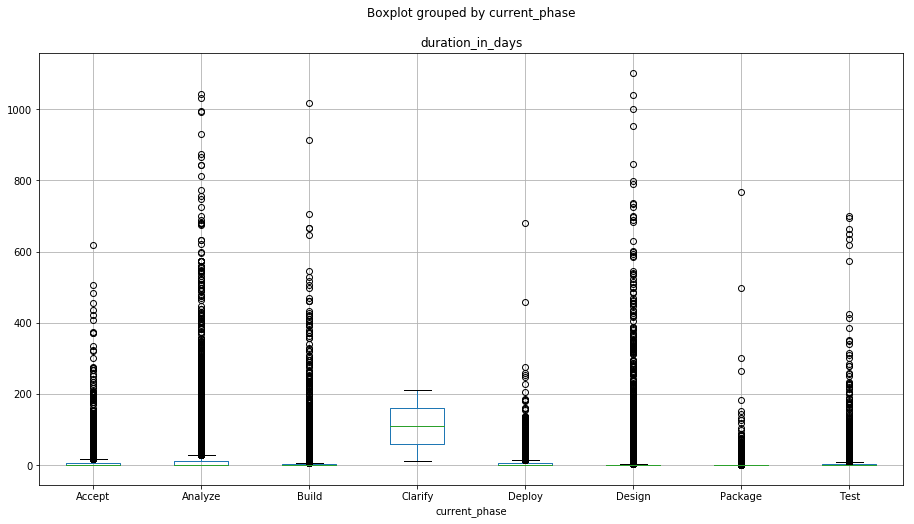

In [16]:
times_closed.boxplot(column="duration_in_days", by="current_phase", figsize=(15,8))
plt.show()

We see that the single phases are dominated by outliers.
We should check if there is a correlation between the phases and the other features to get information about which tickets run through which phase.

1. Work Priority

In [17]:
cross = pd.crosstab(times_closed["current_phase"], times_closed["work_priority"])
cross = cross.reindex(categories)

In [18]:
cross.apply(lambda x: x/x[x.index[0]])

work_priority,WP_00001,WP_00002,WP_00003,WP_00004,WP_00005
current_phase,,,,,
Analyze,1.000000,1.000000,1.000000,1.000000,1.000000
Design,0.904691,0.920585,0.906671,0.871278,0.833333
Build,0.795979,0.859344,0.860007,0.811734,0.761905
Test,0.438570,0.534176,0.618389,0.547285,0.549383
Package,0.391660,0.458712,0.524542,0.460595,0.470899
Accept,0.689501,0.727776,0.681300,0.666375,0.545855
Deploy,0.626210,0.620703,0.594711,0.576182,0.496473
Clarify,0.000000,0.000000,0.000346,0.000000,0.000000


The table shows the percentage of the work prioritys running through the phases, f.e. WP1 100% start at Analyze, 90% got to Design, 79% go to Build, 43% go to Test and so on.
It seems like with increasing work priority the length of the process decreases. We should verify this.

In [19]:
times_closed.loc[:, "work_priority"] = times_closed["work_priority"].astype('category')

C:\Users\marcelfe\AppData\Local\Continuum\anaconda3\envs\GDSC\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


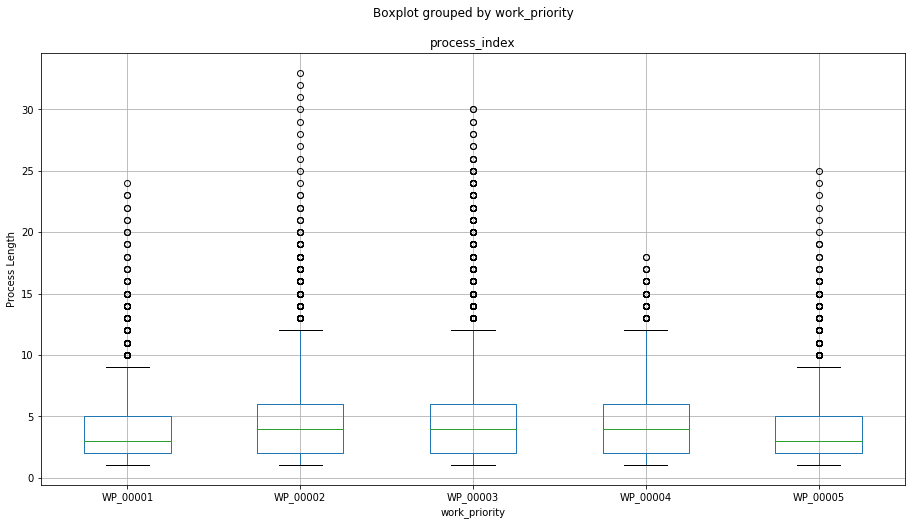

In [20]:
times_closed.boxplot(column="process_index", by="work_priority", figsize=(15,8))
plt.ylabel("Process Length")
plt.show()

This looks like a even distribution or a small gauss distribution because the minimum and maximum WP's have a shorter process length then the other ones.

2. Work Type

In [21]:
cross = pd.crosstab(times_closed["current_phase"], times_closed["work_type"])
cross = cross.reindex(categories)

In [22]:
cross.apply(lambda x: x/x[x.index[0]])

work_type,WT_00001,WT_00002,WT_00003
current_phase,,,
Analyze,1.000000,1.000000,1.000000
Design,0.899038,0.887421,0.907475
Build,0.884386,0.766038,0.845943
Test,0.701236,0.276415,0.643801
Package,0.578297,0.247799,0.562443
Accept,0.717720,0.606918,0.689380
Deploy,0.593407,0.559119,0.616226
Clarify,0.000229,0.000314,0.000000


We can see that only 27% from tickets of WT2 are tested, seems like they are fixes that don't need a test. We should look if this has an impact of the total process length

In [23]:
times_closed.loc[:, "work_type"] = times_closed["work_type"].astype('category')

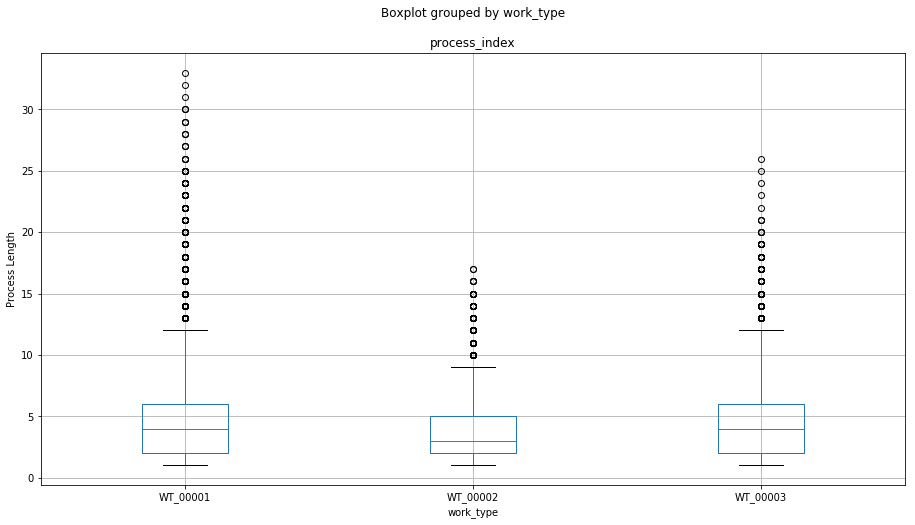

In [24]:
times_closed.boxplot(column="process_index", by="work_type", figsize=(15,8))
plt.ylabel("Process Length")
plt.show()

Yes it has. WT2 has less outliers than the other ones and however a shorter process than the other ones

3. Domain

In [25]:
cross = pd.crosstab(times_closed["current_phase"], times_closed["domain"])
cross = cross.reindex(categories)

In [26]:
cross

domain,BD_00001,BD_00002,BD_00003,BD_00004,BD_00005,BD_00006,BD_00007,BD_00008,BD_00009,BD_00010,BD_00011
current_phase,,,,,,,,,,,
Analyze,965,2691,1461,568,2186,857,1058,662,488,627,373
Design,971,2280,1450,433,1825,787,961,597,490,605,332
Build,861,2032,1461,390,1952,713,851,551,467,499,234
Test,543,1592,688,244,1723,459,622,211,211,332,142
Package,500,1433,550,244,1366,414,590,162,130,264,129
Accept,781,1720,1258,441,1167,675,852,520,271,274,131
Deploy,696,1412,1091,334,1195,556,726,414,223,296,131
Clarify,0,0,0,0,0,0,1,0,0,0,1


I don't see a big difference  according to the domain.

4. Platform

In [27]:
cross = pd.crosstab(times_closed["current_phase"], times_closed["platform"])
cross = cross.reindex(categories)

In [28]:
cross

platform,PL_00001,PL_00002,PL_00003,PL_00004,PL_00005,PL_00006,PL_00007,PL_00008,PL_00009,PL_00010,PL_00011,PL_00012,PL_00013,PL_00014,PL_00015,PL_00016,PL_00017,PL_00018,PL_00019
current_phase,,,,,,,,,,,,,,,,,,,
Analyze,965,2691,793,333,2186,554,215,668,441,303,235,843,153,68,65,627,108,265,423
Design,971,2280,870,248,1825,532,205,580,412,255,185,756,126,59,61,605,93,239,429
Build,861,2032,818,233,1952,496,198,643,392,217,157,653,108,51,31,499,56,178,436
Test,543,1592,201,129,1723,301,178,487,120,158,115,444,77,14,22,332,19,123,189
Package,500,1433,181,129,1366,271,168,369,74,143,115,422,75,13,17,264,17,112,113
Accept,781,1720,691,276,1167,478,210,567,370,197,165,642,106,44,25,274,24,107,246
Deploy,696,1412,643,190,1195,388,173,448,288,168,144,553,85,41,21,296,23,108,202
Clarify,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


We can summarize the following:
1. Work priority and process length are even distributed, WP1 and WP5 could be significant
2. Work type 2 doesn't need to be tested and however has a shorter process than the other work types
3. Every Work item has to be analyzed